# <center> HW 6: Text Clustering </center>

In this assignment, you'll need to use the following dataset:
- hw_6_train.csv: This file contains a list of documents. It's used for training models
- hw6_test.csv: This file contains a list of documents and their ground-truth labels. It's used for testing performance. This file is in the format shown below. Note, each document has a list of labels.
You can load these files using json.load()

|label| Description|
|----|-------|
|3| The Barguelonne (French: la Barguelonne) is a...|
| 4 |Conus nielsenae is a species of sea snail a m...|

In [4]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from kneed import KneeLocator
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.cluster import KMeansClusterer, cosine_distance,euclidean_distance
from sklearn.cluster import KMeans
from sklearn import mixture
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
import numpy as np
from sklearn.metrics import silhouette_score
from sklearn.metrics import pairwise_distances

In [5]:
train = pd.read_csv("hw6_train.csv")
train.head()

test = pd.read_csv("hw6_test.csv")
test.head()

,description
0,The Barguelonne (French: la Barguelonne) is a...
1,Conus nielsenae is a species of sea snail a m...
2,Coleto Creek Reservoir is a reservoir on Cole...
3,Indian River is a 59.1-mile-long (95.1 km) tr...
4,The Funtenseetauern is a 2579 m high border p...


,label,description
0,4,Onychogomphus styx is a species of dragonfly ...
1,3,The Bonnet Carré Spillway is a flood control ...
2,4,Coleophora centaureivora is a moth of the Col...
3,1,Paris Nogari (c. 1536–1601) was an Italian pa...
4,3,Blacktail Butte (7688 feet (2343 m)) is a but...


## Q1:  Clustering (7 points)

Define a function `clustering` as follows: 
- Take the following parameters:
    - `train_text`: a list of train documents
    - `test_text`: a list of test documents
    - `test_label`: a list ground truth labels for the test documents
    - `num_clusters`: the number of clusters
    - `model`: two possible values, `KMeans` or `GMM` (Gaussian Mixture Model)
    - `metric`: If `model = KMeans`, either `Cosine` or `L2` distance can be chosen. Ignore this metric if `model = GMM`
    
    
- Cluster `train_text` into `num_clusters` clusters, using the specific `model` and `metric`
    - Transform the `train_text` and `test_text` into tfidf weights by a vectorizer. Fit the vectorized only by `train_text`
    - When generating tfidf weights, you need to tune parameters such as `stop_words` and `min_df` for better performance
    - Use a number of initializations to make sure the clustering algorithm converges
    
    
- Predict the cluster id for each document in `test_text`
- Apply `majority vote` rule to map the predicted cluster IDs to `test_label`. Hint: 
    - Do not hardcode the mapping in your code because each run may give you a different mapping. You can use `idxmax` function of Pandas to generate the mapping dynamically 
    - You can use cross tabulation to map the clusters to ground truth labels. Check the class notes for details.
- Print the classification report


- Return the fitted clustering model and the tfidf vectorizer.


In [6]:
def clustering(train_text, test_text, test_label, num_clusters, model='KMeans', metric='Cosine'):
    
    clusterer, tfidf_vect = None, None
    cluster_dict = None
    predicted_target=[]
    tfidf_vect =TfidfVectorizer(stop_words="english",min_df=3)
    dtm= tfidf_vect.fit_transform(train_text)
    test_dtm = tfidf_vect.transform(test_text)
    if model=='KMeans':
       
        if metric=='Cosine':
            
            clusterer = KMeansClusterer(num_clusters, cosine_distance, repeats=50,avoid_empty_clusters=True)
            clusters = clusterer.cluster(dtm.toarray(), assign_clusters=True)
            predicted = [clusterer.classify(v) for v in test_dtm.toarray()]
        if metric=='L2':    
            clusterer = KMeans(n_clusters=num_clusters, n_init=20, random_state = 42).fit(dtm)
            predicted = clusterer.predict(test_dtm)
    if model=='GMM':
       
        clusterer = mixture.GaussianMixture(covariance_type='tied', n_components=num_clusters, n_init=20,random_state=42)
        clusterer.fit(dtm.toarray())
        predicted = clusterer.predict(test_dtm.toarray())
    confusion_df = pd.DataFrame(list(zip(test_label.values, predicted)),columns = ["label", "cluster"])
    crosstable=pd.crosstab( index=confusion_df.cluster, columns=confusion_df.label)
    mapping = dict(crosstable.idxmax(axis=1))
    predicted_target = [mapping[i] for i in predicted]

    print(metrics.classification_report(test["label"], predicted_target))

            
        


    
    return clusterer, tfidf_vect

## Q2:  Test your function in the following setups (2 points):
1. `model = GMM`
1. `model = KMeans, metric = L2`
1. `model = KMeans, metric = Cosine`

Note, although the ground truth has 4 labels, it is not necessary that you have to set `num_cluster = 4`. You can set `num_cluster` to a larger number. It is perfectly fine to map multiple clusters to one label, because samples within a label may be distributed differently. For example, American Poetry vs. Frend Poetry may have different textual features.


You may notice these three setups return you very different external evaluation results. Can you explain why this could happen? Write your analysis in a pdf file.

In [2]:
# (1) model = GMM
# (2) model = KMeans, metric = L2
# (3) model = KMeans, metric = Cosine

# The result below is for case (3), KMeans for Cosine. Try to get clustering with about 90% accuracy

In [7]:
clusterer, tfidf_vect=clustering(train["description"], test["description"], test["label"], num_clusters=4, model='KMeans', metric='Cosine')

              precision    recall  f1-score   support

           1       0.95      0.99      0.97       123
           2       0.98      0.97      0.97       100
           3       0.96      0.61      0.74       146
           4       0.70      0.95      0.81       131

    accuracy                           0.87       500
   macro avg       0.90      0.88      0.87       500
weighted avg       0.89      0.87      0.86       500



In [32]:
clusterer, tfidf_vect=clustering(train["description"], test["description"], test["label"], num_clusters=4, model='KMeans', metric='L2')

              precision    recall  f1-score   support

           1       0.45      1.00      0.62       123
           2       0.00      0.00      0.00       100
           3       0.98      0.88      0.93       146
           4       1.00      0.72      0.84       131

    accuracy                           0.69       500
   macro avg       0.61      0.65      0.59       500
weighted avg       0.66      0.69      0.64       500



C:\Users\Matthewxzt\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [33]:
clusterer, tfidf_vect=clustering(train["description"], test["description"], test["label"], num_clusters=4, model='GMM', metric='L2')

              precision    recall  f1-score   support

           1       0.00      0.00      0.00       123
           2       0.97      0.91      0.94       100
           3       0.99      0.92      0.95       146
           4       0.48      0.99      0.65       131

    accuracy                           0.71       500
   macro avg       0.61      0.71      0.64       500
weighted avg       0.61      0.71      0.64       500



C:\Users\Matthewxzt\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Q3: Cluster Interpretation (1 point)

Taking the best model from Q2, can you assign a meaningful name to each cluster? Describe your method and write your result in a pdf file. Show your code if needed.

You can write scripts to interpret each cluster. You don't have to define a function.

Save the screen shots of clusters (e.g. keywords, representative samples etc.) to support your analysis.


In [7]:
clusterer, tfidf_vect=clustering(train["description"], test["description"], test["label"], num_clusters=4, model='KMeans', metric='Cosine')
centroids=np.array(clusterer.means())
sorted_centroids = centroids.argsort()[:, ::-1] 
voc_lookup= tfidf_vect.get_feature_names()
num_clusters=4
for i in range(num_clusters):
    top_words=[voc_lookup[word_index] \
               for word_index in sorted_centroids[i, :20]]
    print("Cluster %d:\n %s " % (i, "; ".join(top_words)))
# add your code here

              precision    recall  f1-score   support

           1       0.95      0.99      0.97       123
           2       0.98      0.97      0.97       100
           3       0.96      0.63      0.76       146
           4       0.71      0.95      0.81       131

    accuracy                           0.87       500
   macro avg       0.90      0.89      0.88       500
weighted avg       0.89      0.87      0.87       500

Cluster 0:
 river; family; species; genus; romania; moth; tributary; moths; gastropod; mollusk; snail; marine; described; geometridae; sea; noctuidae; brazil; snails; arctiidae; endemic 
Cluster 1:
 lake; mountain; located; north; river; range; county; km; south; peak; area; mount; lies; west; mountains; ft; east; elevation; highest; alps 
Cluster 2:
 born; american; known; singer; music; artist; best; writer; songwriter; painter; band; author; composer; producer; musician; january; new; march; work; december 
Cluster 3:
 class; navy; built; ship; war; aircra

## Q4 (Bonus):  Find the best number of clusters (2 points)

It is always challenging to find the best number of clusters for a dataset. Can you describe one method to find the number of clusters which leads to a satsifactory performance in Q2? Implement this method and support your ideas with possible plots.


Text(0.5, 0, 'k')

Text(0, 0.5, 'Sum_of_squared_distances')

Text(0.5, 1.0, 'Elbow Method For Optimal k')

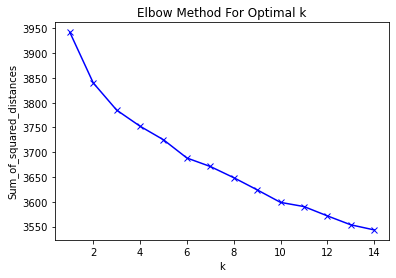

6

In [9]:
# add your code
tfidf_vect = TfidfVectorizer(stop_words="english",min_df=3)
dtm= tfidf_vect.fit_transform(train["description"])
test_dtm = tfidf_vect.transform(test["description"])
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(dtm)
    
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()
kl = KneeLocator(range(1, 15), Sum_of_squared_distances, curve="convex", direction="decreasing")

kl.elbow
#K=6
# I use the kmeans model to build the elbow methond but the picture is not good enough to find the best k. So use the keen packedge to find the elbow. 

Text(0.5, 0, 'k')

Text(0, 0.5, 'Silhouette score')

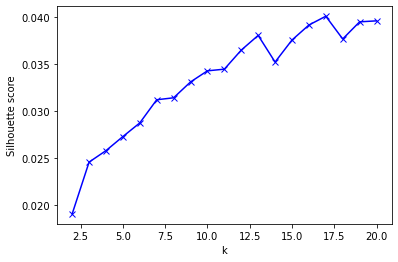

[0.01902570846103041,
 0.02453901170676503,
 0.025762086501110594,
 0.027260833164788303,
 0.028711995550528783,
 0.031176981471434155,
 0.0313865086830857,
 0.03307333926179906,
 0.03425644958121137,
 0.03443423161053968,
 0.03646310838416096,
 0.03802759606708297,
 0.03519183331880699,
 0.03753484018453081,
 0.03913250212898524,
 0.040067149508380445,
 0.037649751148145005,
 0.03947213925446822,
 0.03957578360905508]

In [10]:
sil = []
kmax = 20
tfidf_vect = TfidfVectorizer(stop_words="english",min_df=3)
dtm= tfidf_vect.fit_transform(train["description"])
for k in range(2, kmax+1):
    kmeans = KMeans(n_clusters = k).fit(dtm)
    labels = kmeans.labels_
    sil.append(silhouette_score(dtm, labels, metric = 'euclidean'))
K=range(2,21)
plt.plot(K, sil, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette score')

plt.show()
sil
#K=17
#calculate the silhouette_score to find the highest one and that is the best K.

Text(0.5, 0, 'k')

Text(0, 0.5, 'log(inertia)')

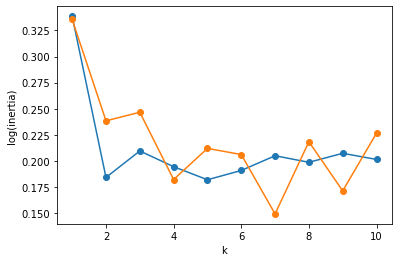

Text(0, 0.5, 'gap')

Text(0.5, 0, 'k')

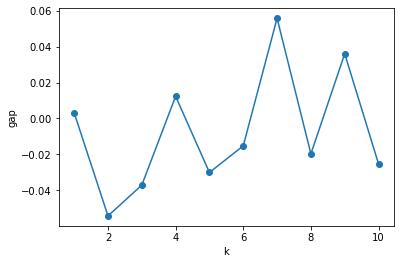

In [11]:
def compute_inertia(a, X):
    W = [np.mean(pairwise_distances(X[a == c, :])) for c in np.unique(a)]
    return np.mean(W)

def compute_gap(clustering, k_max=10, n_references=5):
    tfidf_vect = TfidfVectorizer(stop_words="english",min_df=3)
    dtm= tfidf_vect.fit_transform(train["description"])
    test_dtm = tfidf_vect.transform(test["description"])
    reference_inertia = []
    for k in range(1, k_max+1):
        local_inertia = []
        for _ in range(n_references):
            clustering.n_clusters = k
            assignments = clustering.fit_predict(dtm)
            local_inertia.append(compute_inertia(assignments, dtm))
        reference_inertia.append(np.mean(local_inertia))

    ondata_inertia = []
    for k in range(1, k_max+1):
        clustering.n_clusters = k
        assignments = clustering.fit_predict(test_dtm)
        ondata_inertia.append(compute_inertia(assignments, test_dtm))

    gap = np.log(reference_inertia)-np.log(ondata_inertia)
    return gap, np.log(reference_inertia), np.log(ondata_inertia)

gap, reference_inertia, ondata_inertia = compute_gap(KMeans())


plt.plot(range(1, 11), reference_inertia,
         '-o', label='reference')
plt.plot(range(1, 11), ondata_inertia,
         '-o', label='data')
plt.xlabel('k')
plt.ylabel('log(inertia)')
plt.show()
plt.plot(range(1, 11), gap, '-o')
plt.ylabel('gap')
plt.xlabel('k')
#k=7


## Overall Test

In [34]:
if __name__ == "__main__":  
    
    # Due to randomness, you won't get the exact result
    # as shown here, but your result should be close
    # if you tune the parameters carefully
    
    # Q2
    train = pd.read_csv("hw6_train.csv")
    test = pd.read_csv("hw6_test.csv")
    
    clusterer,tfidf_vect = clustering(train["description"], test["description"], test["label"], \
                                  num_clusters = 5, model = 'KMeans', metric = 'Cosine')

    

              precision    recall  f1-score   support

           1       0.94      0.99      0.96       123
           2       0.98      0.95      0.96       100
           3       0.97      0.98      0.97       146
           4       1.00      0.95      0.98       131

    accuracy                           0.97       500
   macro avg       0.97      0.97      0.97       500
weighted avg       0.97      0.97      0.97       500

